<a href="https://colab.research.google.com/github/adindasyv/2141720096-machinelearning-2023/blob/master/Week%2010/praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1 : RNN untuk Analisis Sentimen

### Setuo

In [5]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [6]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Setup Input Pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini akan mengambalikan dataset (teks, pasangan label)

In [8]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini

In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"Sad story of a downed B-17 pilot. Brady is shot down over occupied territory. The local ranchers extended him kindness and protection at the cost of their own lives. I had never heard of this movie and it snagged me for two hours. After the film is over, I'm glad I took the time. It's an entire story told to explain the look on Brady's face at the start of the film."
 b'I respect Alex Cox the filmmaker, I really do. He\'s like the kid at school who you think at first is just trying a little too hard to be "different", a literary punk-rocker who has dipped more than his feet into spaghetti westerns and science fiction and fringe-culture and come out into the world ready to take s*** on... but then you see what he can actually do, the talent and raw feverish artistry and moments of true absurd hilarity capable of him, and you are ready to see whatever he has to offer. But there\'s two sides to his proverbial coin: he can either really hit it out of the park (Repo Man, Sid & Na

### Buat Teks Encoder
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap)

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[614,  64,   5, ...,   0,   0,   0],
       [ 10,   1,   1, ...,   0,   0,   0],
       [213,  43,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Sad story of a downed B-17 pilot. Brady is shot down over occupied territory. The local ranchers extended him kindness and protection at the cost of their own lives. I had never heard of this movie and it snagged me for two hours. After the film is over, I'm glad I took the time. It's an entire story told to explain the look on Brady's face at the start of the film."
Round-trip:  sad story of a [UNK] [UNK] [UNK] [UNK] is shot down over [UNK] [UNK] the local [UNK] [UNK] him [UNK] and [UNK] at the [UNK] of their own lives i had never heard of this movie and it [UNK] me for two hours after the film is over im [UNK] i took the time its an entire story told to [UNK] the look on [UNK] face at the start of the film                                                                                                                                                                                                                                                                              

### Buat Model

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan

In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00353771]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama

In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[-0.00353771]


Compile model keras untuk mengonfigurasi proses pelatihan

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [19]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 104ms/step - loss: 0.6530 - accuracy: 0.5501 - val_loss: 0.5890 - val_accuracy: 0.4922
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.5066 - accuracy: 0.7264 - val_loss: 0.4272 - val_accuracy: 0.7984
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3758 - accuracy: 0.8290 - val_loss: 0.3628 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3386 - accuracy: 0.8518 - val_loss: 0.3465 - val_accuracy: 0.8458
Epoch 5/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3237 - accuracy: 0.8589 - val_loss: 0.3352 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3146 - accuracy: 0.8646 - val_loss: 0.3311 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3114 - accuracy: 0.8657 - val_loss: 0.3269 - val_accuracy

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 45ms/step - loss: 0.3194 - accuracy: 0.8555
Test Loss: 0.31942272186279297
Test Accuracy: 0.8554800152778625


(0.0, 0.6704672157764435)

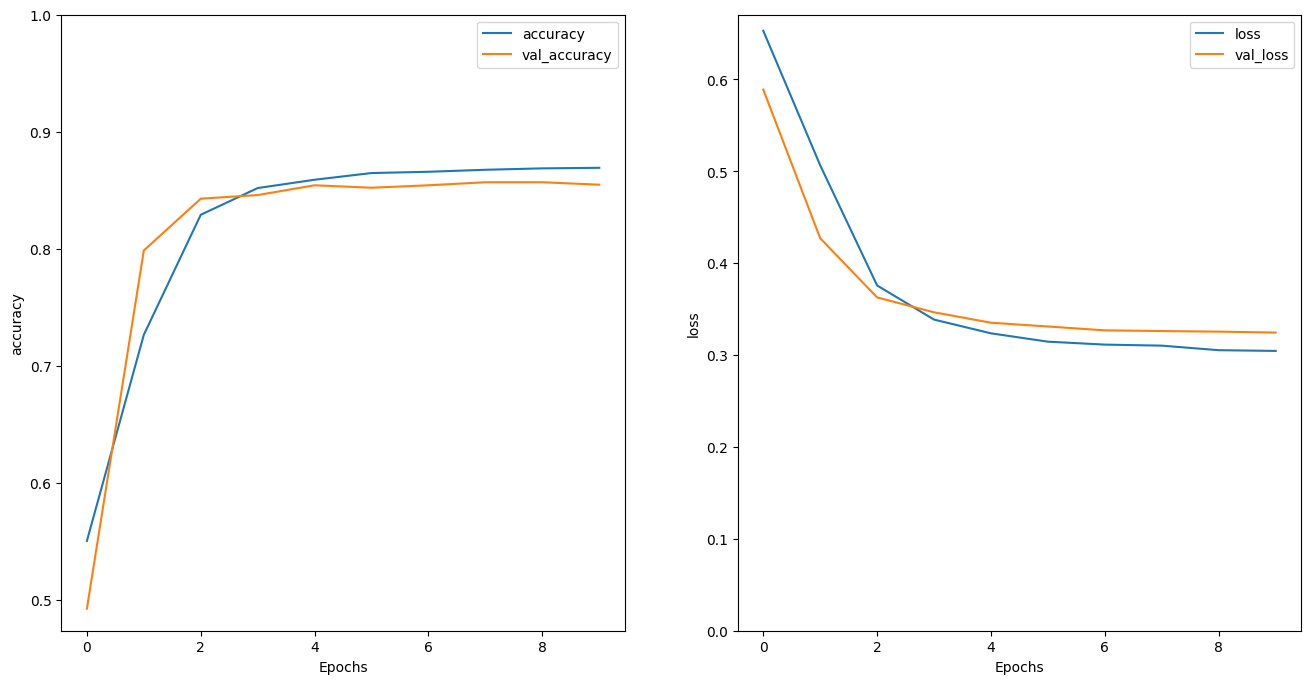

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.69203424]


### Stack Two or More LSTM Layers

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 157ms/step - loss: 0.6279 - accuracy: 0.5793 - val_loss: 0.4335 - val_accuracy: 0.7844
Epoch 2/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3799 - accuracy: 0.8298 - val_loss: 0.3590 - val_accuracy: 0.8307
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3350 - accuracy: 0.8547 - val_loss: 0.3431 - val_accuracy: 0.8349
Epoch 4/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3180 - accuracy: 0.8622 - val_loss: 0.3281 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3124 - accuracy: 0.8652 - val_loss: 0.3214 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3063 - accuracy: 0.8649 - val_loss: 0.3224 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3029 - accuracy: 0.8696 - val_loss: 0.3239 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.3182 - accuracy: 0.8611
Test Loss: 0.3182411789894104
Test Accuracy: 0.8611199855804443


In [28]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.9704098]]


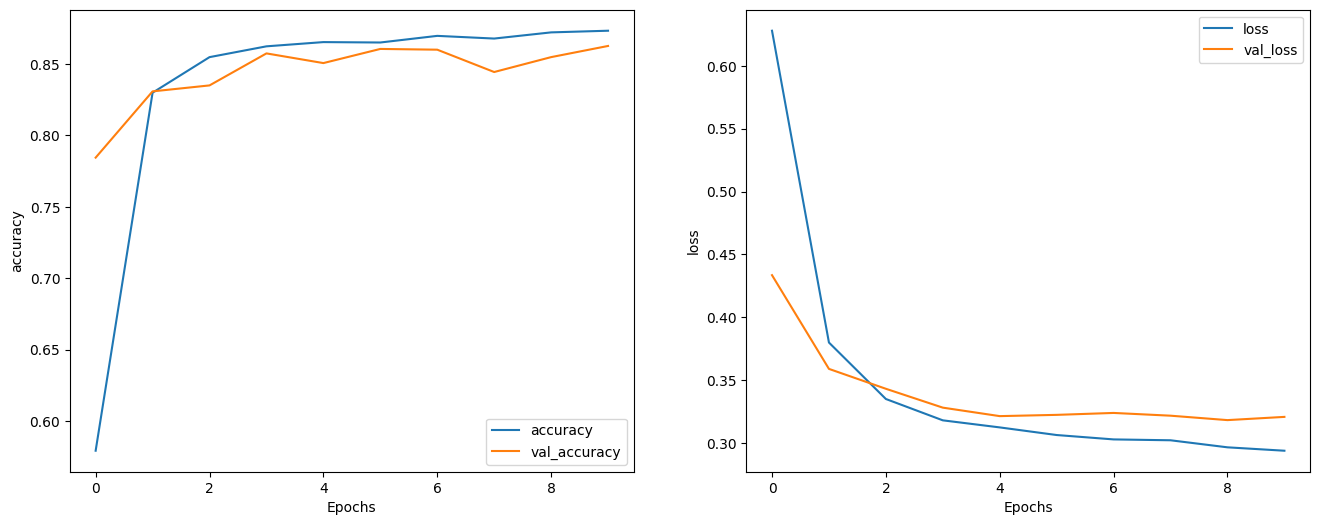

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')